In [22]:
import random
import itertools
import pandas as pd
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt

plt.style.use('default')

# Weights for improved AODV
ALPHA = 0.5   # battery penalty
BETA  = 0.3   # link quality penalty
GAMMA = 0.2   # load penalty


In [23]:
class Node:
    def __init__(self, node_id, battery, load):
        self.id = node_id
        self.battery = battery      # 0..1
        self.load = load            # 0..3
        self.neighbors = {}         # neighbor_id : LQ

    def add_neighbor(self, other, link_quality):
        self.neighbors[other.id] = link_quality


In [24]:
def calculate_node_cost(node, prev_node_id=None):
    # Battery penalty: higher when battery is low
    battery_term = ALPHA * (1 - node.battery)

    # Link quality penalty
    if prev_node_id is None:
        link_term = 0
    else:
        LQ = node.neighbors[prev_node_id]
        link_term = BETA * (1 / LQ)

    # Load (queue length)
    load_term = GAMMA * (node.load / 3)

    return battery_term + link_term + load_term


In [25]:

def path_cost_details(path, nodes):
    rows = []
    prev = None
    total = 0

    for nid in path:
        node = nodes[nid]
        cost = calculate_node_cost(node, prev)
        total += cost

        rows.append({
            "Node": nid,
            "Battery": round(node.battery, 3),
            "Load": node.load,
            "LinkQ": round(node.neighbors.get(prev, 0), 3) if prev else "",
            "Node Cost": round(cost, 4),
            "Accumulated": round(total, 4)
        })

        prev = nid

    return total, pd.DataFrame(rows)


In [26]:

def find_all_paths(nodes, start, end, path=None):
    if path is None:
        path = []
    path = path + [start]

    if start == end:
        return [path]

    paths = []
    for neigh in nodes[start].neighbors:
        if neigh not in path:
            newp = find_all_paths(nodes, neigh, end, path)
            for np in newp:
                paths.append(np)

    return paths


In [27]:

def classic_aodv_best_path(nodes, start, end):
    all_paths = find_all_paths(nodes, start, end)
    all_paths.sort(key=lambda p: len(p))
    return all_paths[0]


In [28]:

def draw_two_diagrams(nodes, classic_path, improved_path):
    G = nx.DiGraph()

    for nid, node in nodes.items():
        G.add_node(nid, battery=node.battery)

    for nid, node in nodes.items():
        for neigh, LQ in node.neighbors.items():
            G.add_edge(nid, neigh, weight=LQ)

    pos = nx.spring_layout(G, seed=42)

    # Color by battery
    node_colors = []
    for nid in G.nodes():
        b = G.nodes[nid]['battery']
        if b > 0.75: node_colors.append("green")
        elif b > 0.5: node_colors.append("yellow")
        elif b > 0.3: node_colors.append("orange")
        else: node_colors.append("red")

    fig, axes = plt.subplots(1, 2, figsize=(16,7))

    ax = axes[0]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                           edge_color="gray", width=1, alpha=0.4,
                           arrows=True, ax=ax)

    classic_edges = [(classic_path[i], classic_path[i+1]) for i in range(len(classic_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=classic_edges,
                           edge_color="red", width=3,
                           arrows=True, ax=ax)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels={(u,v): G.edges[u,v]["weight"] for u,v in G.edges()},
        font_size=8, ax=ax)

    ax.set_title("Classic AODV Best Path (Red)")
    ax.axis("off")

    ax = axes[1]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                           edge_color="gray", width=1, alpha=0.4,
                           arrows=True, ax=ax)

    improved_edges = [(improved_path[i], improved_path[i+1]) for i in range(len(improved_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=improved_edges,
                           edge_color="blue", width=4,
                           arrows=True, ax=ax)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels={(u,v): G.edges[u,v]["weight"] for u,v in G.edges()},
        font_size=8, ax=ax)

    ax.set_title("Improved AODV Best Path (Blue)")
    ax.axis("off")

    plt.show()


In [29]:

def compare_protocols(nodes, start, end):
    all_paths = find_all_paths(nodes, start, end)

    print("\nALL CANDIDATE PATHS\n")

    best_cost = float("inf")
    best_path = None
    best_df = None

    for p in all_paths:
        cost, df = path_cost_details(p, nodes)
        print(f"\nPath {p}, Cost = {round(cost,4)}, Hops = {len(p)-1}")
        display(df)

        if cost < best_cost:
            best_cost = cost
            best_path = p
            best_df = df

    classic = classic_aodv_best_path(nodes, start, end)

    print("\nCLASSIC AODV RESULT\n")
    print("Best Path:", classic)
    print("Hop Count:", len(classic)-1)

    print("\nIMPROVED AODV RESULT\n")
    print("Best Path:", best_path)
    print("Total Cost:", round(best_cost,4))
    display(best_df)

    draw_two_diagrams(nodes, classic, best_path)


In [30]:
def test_case_1():
    nodesA = {
        1: Node(1, 0.90, 0),
        2: Node(2, 0.01, 0),   # dying intermediate hop
        3: Node(3, 0.95, 0),
        4: Node(4, 0.96, 0),
        6: Node(6, 0.92, 0),
    }

    # Shortest path (classic AODV will pick)
    nodesA[1].add_neighbor(nodesA[2], 0.95)
    nodesA[2].add_neighbor(nodesA[6], 0.95)

    # Longer but safe path (improved AODV should pick)
    nodesA[1].add_neighbor(nodesA[3], 0.95)
    nodesA[3].add_neighbor(nodesA[4], 0.95)
    nodesA[4].add_neighbor(nodesA[6], 0.95)

    # Make links bidirectional
    for a in [1,2,3,4,6]:
        for b in nodesA[a].neighbors.keys():
            if a not in nodesA[b].neighbors:
                nodesA[b].add_neighbor(nodesA[a], nodesA[a].neighbors[b])

    print("\nTEST CASE 1 — BATTERY DOMINATES")
    compare_protocols(nodesA, 1, 6)

In [31]:

def test_case_2():
    nodesB = {
        1: Node(1, 0.90, 0),
        4: Node(4, 0.05, 3),
        2: Node(2, 0.90, 0),
        3: Node(3, 0.92, 0),
        6: Node(6, 0.90, 0),
    }

    nodesB[1].add_neighbor(nodesB[4], 0.20)
    nodesB[4].add_neighbor(nodesB[1], 0.20)
    nodesB[4].add_neighbor(nodesB[6], 0.20)
    nodesB[6].add_neighbor(nodesB[4], 0.20)

    for (a,b,lq) in [(1,2,0.95),(2,3,0.95),(3,6,0.95)]:
        nodesB[a].add_neighbor(nodesB[b], lq)
        nodesB[b].add_neighbor(nodesB[a], lq)

    print("\nTEST CASE 2 — CONGESTED RELAY NODE\n")
    compare_protocols(nodesB, 1, 6)


In [32]:

def test_case_3():
    nodesC = {
        1: Node(1, 0.90, 0),
        4: Node(4, 0.90, 0),
        2: Node(2, 0.90, 0),
        3: Node(3, 0.90, 0),
        6: Node(6, 0.90, 0),
    }

    # Very poor direct link
    nodesC[1].add_neighbor(nodesC[6], 0.05)
    nodesC[6].add_neighbor(nodesC[1], 0.05)

    # Great multi-hop
    for (a,b,lq) in [(1,4,0.95),(4,6,0.95),(1,2,0.95),(2,3,0.95),(3,6,0.95)]:
        nodesC[a].add_neighbor(nodesC[b], lq)
        nodesC[b].add_neighbor(nodesC[a], lq)

    print("\nTEST CASE 3 — LINK QUALITY DOMINATES")
    compare_protocols(nodesC, 1, 6)


In [33]:

def random_case():
    N = 6
    nodes = {}

    for i in range(1, N+1):
        nodes[i] = Node(
            i,
            battery=round(random.uniform(0.30,1.00),2),
            load=random.randint(0,3)
        )

    for i in range(1, N+1):
        for j in range(i+1, N+1):
            if random.random() < 0.6:
                LQ = round(random.uniform(0.1,1.0),2)
                nodes[i].add_neighbor(nodes[j], LQ)
                nodes[j].add_neighbor(nodes[i], LQ)

    print("\nRANDOM TEST CASE\n")
    compare_protocols(nodes, 1, 6)


In [34]:
def compute_adaptive_weights_with_report(nodes):
    """
    Computes adaptive weights α, β, γ using:
        α ∝ (1 - avg_battery)
        β ∝ (1 - avg_link_quality)
        γ ∝ (avg_load / 3)
    All normalized so α + β + γ = 1.
    """

    bat = [n.battery for n in nodes.values()]
    load = [n.load for n in nodes.values()]
    lqs = []
    for n in nodes.values():
        for q in n.neighbors.values():
            lqs.append(q)

    avg_bat  = sum(bat)  / len(bat)
    avg_load = sum(load) / len(load)
    avg_lq   = sum(lqs)  / len(lqs) if lqs else 1

    # risk factors
    inv_bat  = 1 - avg_bat
    inv_lq   = 1 - avg_lq
    inv_load = avg_load / 3

    S = inv_bat + inv_lq + inv_load
    A = inv_bat  / S
    B = inv_lq   / S
    C = inv_load / S

    print("\nADAPTIVE WEIGHT REPORT")
    print(f"Average Battery  = {avg_bat:.3f}")
    print(f"Average LinkQ    = {avg_lq:.3f}")
    print(f"Average Load     = {avg_load:.3f}")
    print("\nRisk Components:")
    print(f"  Battery Risk = {inv_bat:.3f}")
    print(f"  Link Risk    = {inv_lq:.3f}")
    print(f"  Load Risk    = {inv_load:.3f}")
    print("\nNormalized Weights:")
    print(f"  α = {A:.3f}")
    print(f"  β = {B:.3f}")
    print(f"  γ = {C:.3f}")
    print(f"  (Sum = {A+B+C:.3f})")

    return A, B, C


In [35]:
def calculate_node_cost_adaptive(node, prev_node_id, A, B, C):
    battery_term = A * (1 - node.battery)

    if prev_node_id is None:
        link_term = 0
    else:
        LQ = node.neighbors[prev_node_id]
        link_term = B * (1 / LQ)

    load_term = C * (node.load / 3)

    return battery_term + link_term + load_term


In [36]:
def path_cost_details_adaptive(path, nodes, A, B, C):
    rows = []
    prev = None
    total = 0

    for nid in path:
        node = nodes[nid]
        cost = calculate_node_cost_adaptive(node, prev, A, B, C)
        total += cost

        rows.append({
            "Node": nid,
            "Battery": round(node.battery,3),
            "Load": node.load,
            "LinkQ": node.neighbors.get(prev, "") if prev else "",
            "Cost": round(cost,4),
            "Accumulated": round(total,4),
        })

        prev = nid

    return total, pd.DataFrame(rows)


In [37]:
def compare_protocols_three(nodes, start, end):
    paths = find_all_paths(nodes, start, end)

    # Compute adaptive weights first
    A, B, C = compute_adaptive_weights_with_report(nodes)

    best_fixed = (None, float("inf"), None)
    best_adapt = (None, float("inf"), None)

    print("\nALL PATHS (Fixed vs Adaptive)")

    for p in paths:
        fixed_cost, fixed_df = path_cost_details(p, nodes)
        adapt_cost, adapt_df = path_cost_details_adaptive(p, nodes, A, B, C)

        print(f"\nPATH {p}")
        print(f" Fixed Cost    = {round(fixed_cost,4)}")
        print(f" Adaptive Cost = {round(adapt_cost,4)}")

        if fixed_cost < best_fixed[1]:
            best_fixed = (p, fixed_cost, fixed_df)

        if adapt_cost < best_adapt[1]:
            best_adapt = (p, adapt_cost, adapt_df)

        print("\n--- Fixed Table ---")
        display(fixed_df)
        print("\n--- Adaptive Table ---")
        display(adapt_df)

    classic = classic_aodv_best_path(nodes, start, end)

    print("\nFINAL RESULTS")
    print("CLASSIC AODV      :", classic)
    print("FIXED-WEIGHT AODV :", best_fixed[0], "Cost =", round(best_fixed[1],4))
    print("ADAPTIVE AODV     :", best_adapt[0], "Cost =", round(best_adapt[1],4))

    draw_three_diagrams(nodes, classic, best_fixed[0], best_adapt[0])


In [38]:
def draw_three_diagrams(nodes, classic_path, fixed_path, adapt_path):
    G = nx.DiGraph()
    for nid, node in nodes.items():
        G.add_node(nid, battery=node.battery)
        for neigh, LQ in node.neighbors.items():
            G.add_edge(nid, neigh, weight=LQ)

    pos = nx.spring_layout(G, seed=42)

    node_colors = []
    for nid in G.nodes():
        b = G.nodes[nid]["battery"]
        if b > 0.75: node_colors.append("green")
        elif b > 0.5: node_colors.append("yellow")
        elif b > 0.3: node_colors.append("orange")
        else: node_colors.append("red")

    fig, ax = plt.subplots(1, 3, figsize=(22,6))

    # CLASSIC
    nx.draw(G, pos, node_color=node_colors, with_labels=True, ax=ax[0])
    nx.draw_networkx_edges(G, pos,
       edgelist=[(classic_path[i], classic_path[i+1]) for i in range(len(classic_path)-1)],
       edge_color="red", width=3, ax=ax[0])
    ax[0].set_title("Classic AODV")

    # FIXED
    nx.draw(G, pos, node_color=node_colors, with_labels=True, ax=ax[1])
    nx.draw_networkx_edges(G, pos,
       edgelist=[(fixed_path[i], fixed_path[i+1]) for i in range(len(fixed_path)-1)],
       edge_color="blue", width=3, ax=ax[1])
    ax[1].set_title("Fixed-Weight AODV")

    # ADAPTIVE
    nx.draw(G, pos, node_color=node_colors, with_labels=True, ax=ax[2])
    nx.draw_networkx_edges(G, pos,
       edgelist=[(adapt_path[i], adapt_path[i+1]) for i in range(len(adapt_path)-1)],
       edge_color="purple", width=3, ax=ax[2])
    ax[2].set_title("Adaptive AODV")

    plt.show()


In [39]:
def test_case_1_three():
    nodes = {
        1: Node(1, 0.90, 0),
        2: Node(2, 0.05, 0), 
        3: Node(3, 0.85, 0),
        4: Node(4, 0.80, 1),
        6: Node(6, 0.90, 0)
    }

    # BAD short path: 1–2–6
    nodes[1].add_neighbor(nodes[2], 0.90)
    nodes[2].add_neighbor(nodes[6], 0.92)

    # Healthy alternative: 1–3–4–6
    for (a,b,lq) in [(1,3,0.95),(3,4,0.96),(4,6,0.97)]:
        nodes[a].add_neighbor(nodes[b], lq)

    for a in nodes:
        for b, lq in list(nodes[a].neighbors.items()):
            if a not in nodes[b].neighbors:
                nodes[b].add_neighbor(nodes[a], lq)

    print("\nTEST CASE 1 — BATTERY DOMINANT (3 protocols)")
    compare_protocols_three(nodes, 1, 6)

def test_case_2_three():
    nodes = {
        1: Node(1,0.90,0),
        2: Node(2,0.70,0),
        3: Node(3,0.78,2),
        4: Node(4,0.80,3),
        6: Node(6,0.90,0)
    }

    # Bad short path 1–4–6
    nodes[1].add_neighbor(nodes[4],0.65)
    nodes[4].add_neighbor(nodes[6],0.60)

    # Good multi-hop 1–2–3–6
    for (a,b,lq) in [(1,2,0.95),(2,3,0.90),(3,6,0.92)]:
        nodes[a].add_neighbor(nodes[b],lq)

    for a in nodes:
        for b, lq in list(nodes[a].neighbors.items()):
            if a not in nodes[b].neighbors:
                nodes[b].add_neighbor(nodes[a], lq)

    print("\nTEST CASE 2 — LOAD DOMINANT (3 protocols)")
    compare_protocols_three(nodes,1,6)

def test_case_3_three():
    nodes = {
        1: Node(1,0.90,0),
        2: Node(2,0.85,0),
        3: Node(3,0.87,1),
        6: Node(6,0.90,0)
    }

    nodes[1].add_neighbor(nodes[6],0.05)
    nodes[1].add_neighbor(nodes[2],0.60)
    nodes[2].add_neighbor(nodes[6],0.60)
    nodes[2].add_neighbor(nodes[3],0.95)
    nodes[3].add_neighbor(nodes[6],0.95)

    for a in nodes:
        for b, lq in list(nodes[a].neighbors.items()):
            if a not in nodes[b].neighbors:
                nodes[b].add_neighbor(nodes[a], lq)

    print("\nTEST CASE 3 — LINK QUALITY DOMINANT (3 protocols)")
    compare_protocols_three(nodes,1,6)



COMPARING CLASSIC AODV WITH IMPROVED (FIXED WEIGHTS)

TEST CASE 1 — BATTERY DOMINATES

ALL CANDIDATE PATHS


Path [1, 2, 6], Cost = 1.2166, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.01,0,0.95,0.8108,0.8608
2,6,0.92,0,0.95,0.3558,1.2166



Path [1, 3, 4, 6], Cost = 1.0824, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,3,0.95,0,0.95,0.3408,0.3908
2,4,0.96,0,0.95,0.3358,0.7266
3,6,0.92,0,0.95,0.3558,1.0824



CLASSIC AODV RESULT

Best Path: [1, 2, 6]
Hop Count: 2

IMPROVED AODV RESULT

Best Path: [1, 3, 4, 6]
Total Cost: 1.0824


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,3,0.95,0,0.95,0.3408,0.3908
2,4,0.96,0,0.95,0.3358,0.7266
3,6,0.92,0,0.95,0.3558,1.0824


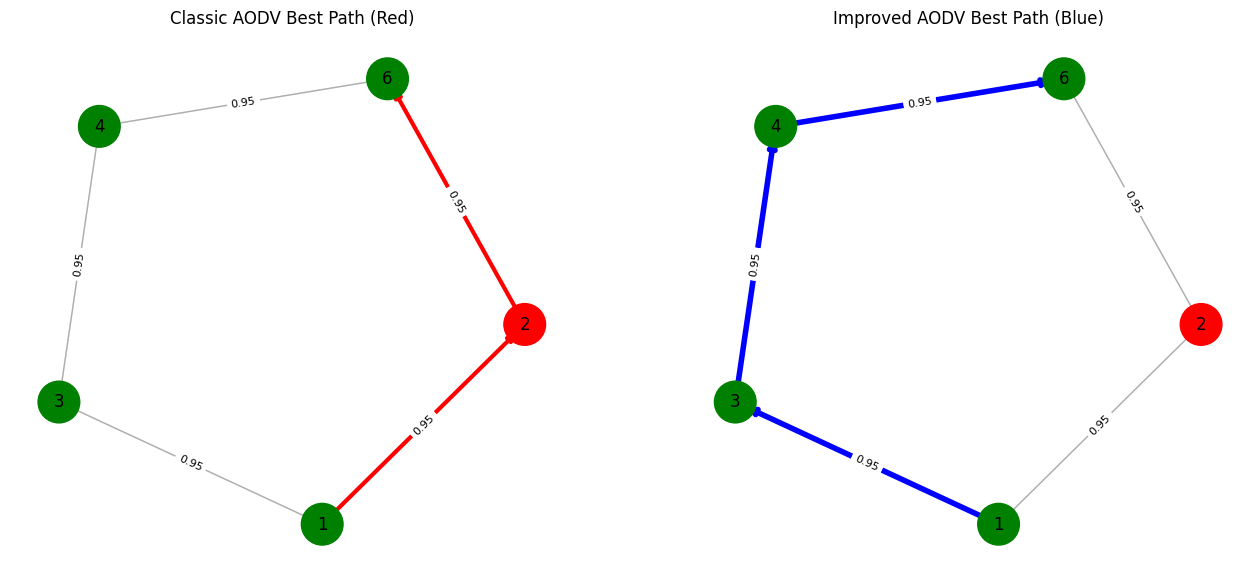


TEST CASE 2 — CONGESTED RELAY NODE


ALL CANDIDATE PATHS


Path [1, 4, 6], Cost = 3.775, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.050,0.050
1,4,0.05,3,0.2,2.175,2.225
2,6,0.90,0,0.2,1.550,3.775



Path [1, 2, 3, 6], Cost = 1.1374, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.90,0,0.95,0.3658,0.4158
2,3,0.92,0,0.95,0.3558,0.7716
3,6,0.90,0,0.95,0.3658,1.1374



CLASSIC AODV RESULT

Best Path: [1, 4, 6]
Hop Count: 2

IMPROVED AODV RESULT

Best Path: [1, 2, 3, 6]
Total Cost: 1.1374


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.90,0,0.95,0.3658,0.4158
2,3,0.92,0,0.95,0.3558,0.7716
3,6,0.90,0,0.95,0.3658,1.1374


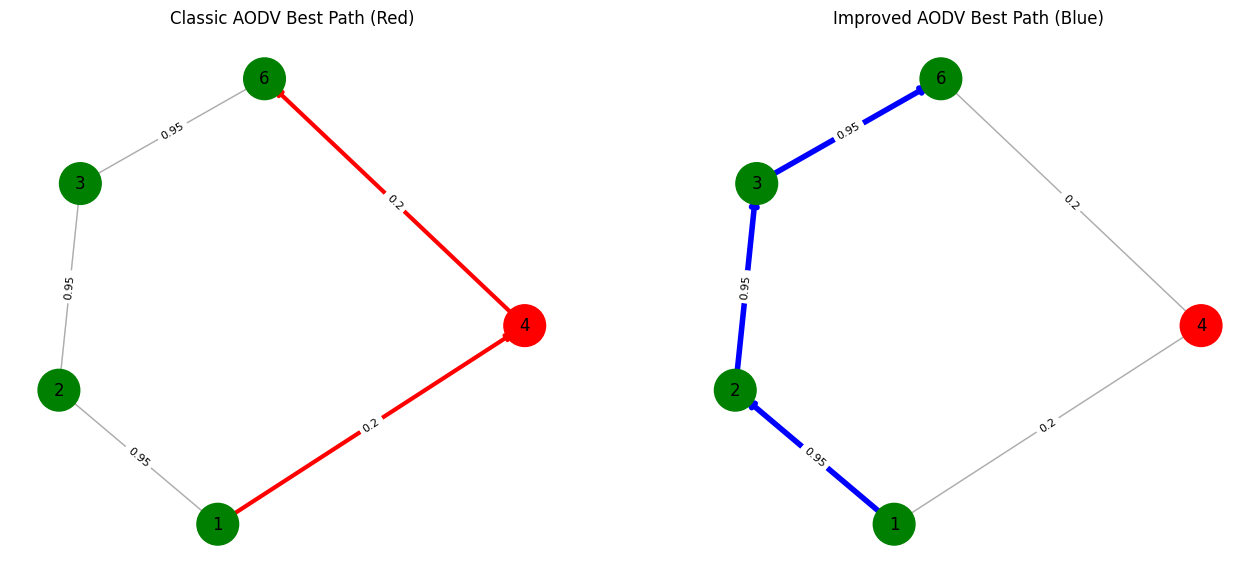


TEST CASE 3 — LINK QUALITY DOMINATES

ALL CANDIDATE PATHS


Path [1, 6], Cost = 6.1, Hops = 1


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.05,0.05
1,6,0.9,0,0.05,6.05,6.10



Path [1, 4, 6], Cost = 0.7816, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,4,0.9,0,0.95,0.3658,0.4158
2,6,0.9,0,0.95,0.3658,0.7816



Path [1, 2, 3, 6], Cost = 1.1474, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,2,0.9,0,0.95,0.3658,0.4158
2,3,0.9,0,0.95,0.3658,0.7816
3,6,0.9,0,0.95,0.3658,1.1474



CLASSIC AODV RESULT

Best Path: [1, 6]
Hop Count: 1

IMPROVED AODV RESULT

Best Path: [1, 4, 6]
Total Cost: 0.7816


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,4,0.9,0,0.95,0.3658,0.4158
2,6,0.9,0,0.95,0.3658,0.7816


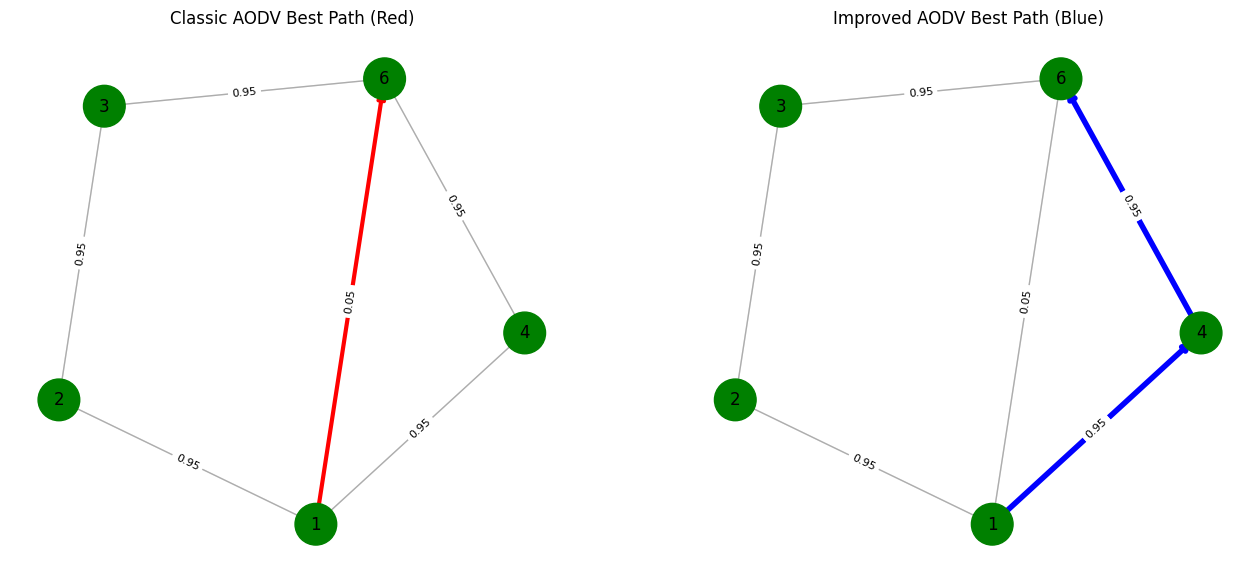


RANDOM TEST CASE


ALL CANDIDATE PATHS


Path [1, 3, 4, 2, 5, 6], Cost = 5.864, Hops = 5


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,3,0.57,1,0.19,1.8606,2.1456
2,4,0.54,1,0.51,0.8849,3.0305
3,2,0.34,1,0.35,1.2538,4.2843
4,5,0.92,2,0.36,1.0067,5.2910
5,6,0.86,3,0.99,0.5730,5.8640



Path [1, 3, 4, 5, 6], Cost = 4.2769, Hops = 4


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,3,0.57,1,0.19,1.8606,2.1456
2,4,0.54,1,0.51,0.8849,3.0305
3,5,0.92,2,0.6,0.6733,3.7038
4,6,0.86,3,0.99,0.5730,4.2769



Path [1, 3, 5, 6], Cost = 3.6063, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,3,0.57,1,0.19,1.8606,2.1456
2,5,0.92,2,0.42,0.8876,3.0332
3,6,0.86,3,0.99,0.5730,3.6063



Path [1, 4, 2, 5, 6], Cost = 3.7681, Hops = 4


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,4,0.54,1,0.85,0.6496,0.9346
2,2,0.34,1,0.35,1.2538,2.1884
3,5,0.92,2,0.36,1.0067,3.1951
4,6,0.86,3,0.99,0.5730,3.7681



Path [1, 4, 3, 5, 6], Cost = 3.2652, Hops = 4


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,4,0.54,1,0.85,0.6496,0.9346
2,3,0.57,1,0.51,0.8699,1.8045
3,5,0.92,2,0.42,0.8876,2.6921
4,6,0.86,3,0.99,0.5730,3.2652



Path [1, 4, 5, 6], Cost = 2.181, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,4,0.54,1,0.85,0.6496,0.9346
2,5,0.92,2,0.6,0.6733,1.6079
3,6,0.86,3,0.99,0.5730,2.1810



Path [1, 5, 6], Cost = 1.3928, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,5,0.92,2,0.83,0.5348,0.8198
2,6,0.86,3,0.99,0.5730,1.3928



Path [1, 6], Cost = 3.2823, Hops = 1


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,6,0.86,3,0.11,2.9973,3.2823



CLASSIC AODV RESULT

Best Path: [1, 6]
Hop Count: 1

IMPROVED AODV RESULT

Best Path: [1, 5, 6]
Total Cost: 1.3928


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.43,0,,0.2850,0.2850
1,5,0.92,2,0.83,0.5348,0.8198
2,6,0.86,3,0.99,0.5730,1.3928


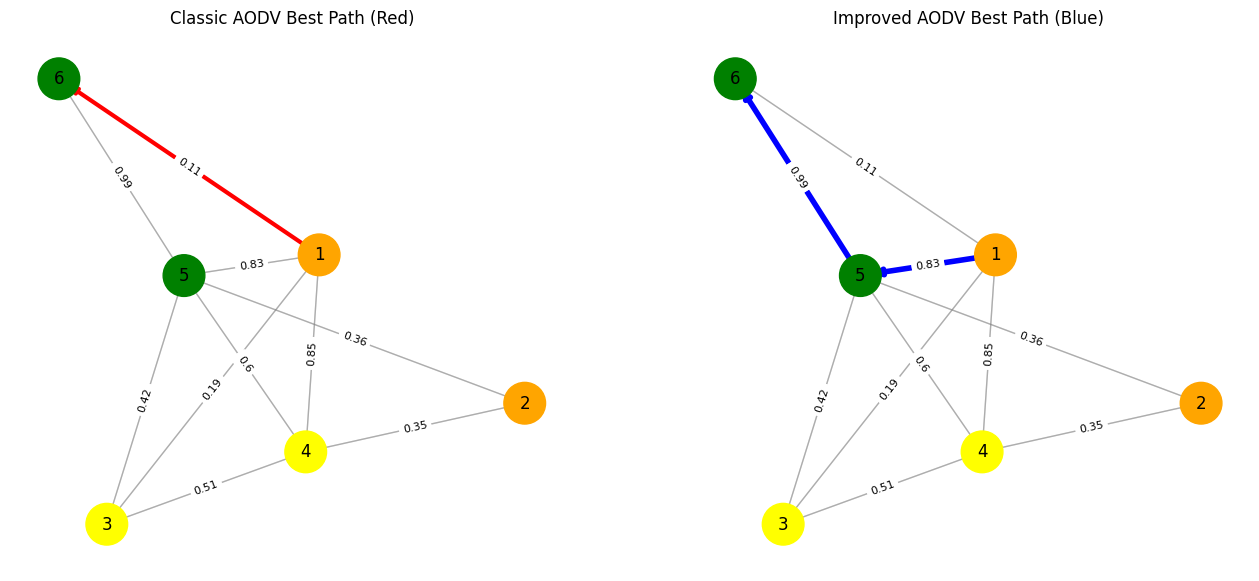

In [44]:
print("\nCOMPARING CLASSIC AODV WITH IMPROVED (FIXED WEIGHTS)")
test_case_1()
test_case_2()
test_case_3()
random_case()


COMPARING CLASSIC AODV WITH IMPROVED (FIXED & ADAPTIVE WEIGHTS)

TEST CASE 1 — BATTERY DOMINANT (3 protocols)

ADAPTIVE WEIGHT REPORT
Average Battery  = 0.700
Average LinkQ    = 0.940
Average Load     = 0.200

Risk Components:
  Battery Risk = 0.300
  Link Risk    = 0.060
  Load Risk    = 0.067

Normalized Weights:
  α = 0.703
  β = 0.141
  γ = 0.156
  (Sum = 1.000)

ALL PATHS (Fixed vs Adaptive)

PATH [1, 2, 6]
 Fixed Cost    = 1.2344
 Adaptive Cost = 1.1177

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.05,0,0.9,0.8083,0.8583
2,6,0.90,0,0.92,0.3761,1.2344



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.90,0,,0.0703,0.0703
1,2,0.05,0,0.9,0.8242,0.8945
2,6,0.90,0,0.92,0.2232,1.1177



PATH [1, 3, 4, 6]
 Fixed Cost    = 1.2792
 Adaptive Cost = 0.8783

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,3,0.85,0,0.95,0.3908,0.4408
2,4,0.80,1,0.96,0.4792,0.9200
3,6,0.90,0,0.97,0.3593,1.2792



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.90,0,,0.0703,0.0703
1,3,0.85,0,0.95,0.2535,0.3238
2,4,0.80,1,0.96,0.3392,0.6630
3,6,0.90,0,0.97,0.2153,0.8783



FINAL RESULTS
CLASSIC AODV      : [1, 2, 6]
FIXED-WEIGHT AODV : [1, 2, 6] Cost = 1.2344
ADAPTIVE AODV     : [1, 3, 4, 6] Cost = 0.8783


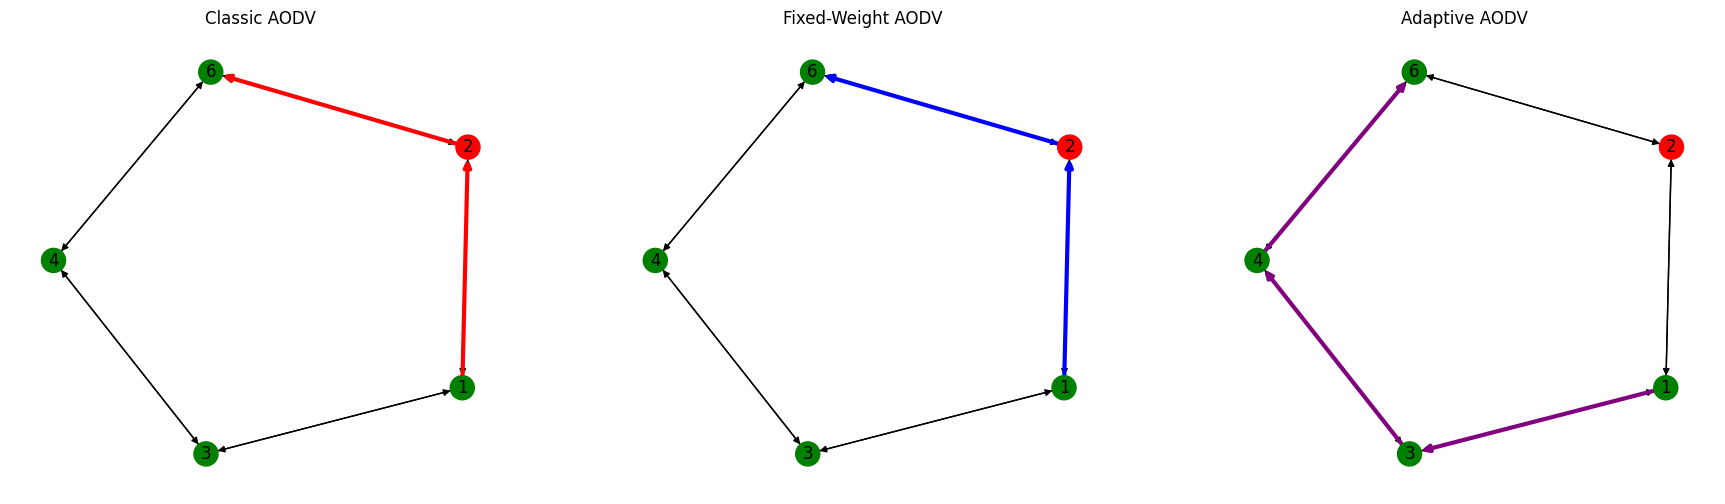


TEST CASE 2 — LOAD DOMINANT (3 protocols)

ADAPTIVE WEIGHT REPORT
Average Battery  = 0.816
Average LinkQ    = 0.804
Average Load     = 1.000

Risk Components:
  Battery Risk = 0.184
  Link Risk    = 0.196
  Load Risk    = 0.333

Normalized Weights:
  α = 0.258
  β = 0.275
  γ = 0.467
  (Sum = 1.000)

ALL PATHS (Fixed vs Adaptive)

PATH [1, 4, 6]
 Fixed Cost    = 1.3615
 Adaptive Cost = 1.4511

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,4,0.8,3,0.65,0.7615,0.8115
2,6,0.9,0,0.6,0.5500,1.3615



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.9,0,,0.0258,0.0258
1,4,0.8,3,0.65,0.9416,0.9674
2,6,0.9,0,0.6,0.4837,1.4511



PATH [1, 2, 3, 6]
 Fixed Cost    = 1.4685
 Adaptive Cost = 1.3904

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.70,0,0.95,0.4658,0.5158
2,3,0.78,2,0.9,0.5767,1.0925
3,6,0.90,0,0.92,0.3761,1.4685



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.90,0,,0.0258,0.0258
1,2,0.70,0,0.95,0.3666,0.3924
2,3,0.78,2,0.9,0.6736,1.0660
3,6,0.90,0,0.92,0.3245,1.3904



FINAL RESULTS
CLASSIC AODV      : [1, 4, 6]
FIXED-WEIGHT AODV : [1, 4, 6] Cost = 1.3615
ADAPTIVE AODV     : [1, 2, 3, 6] Cost = 1.3904


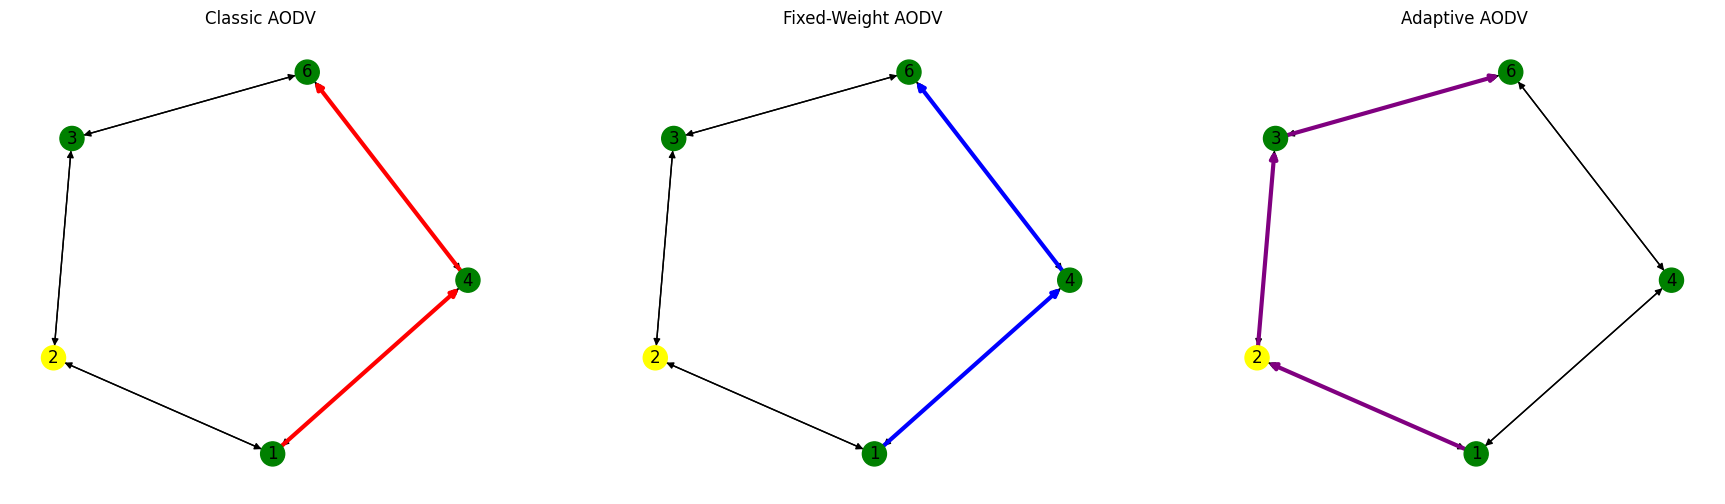


TEST CASE 3 — LINK QUALITY DOMINANT (3 protocols)

ADAPTIVE WEIGHT REPORT
Average Battery  = 0.880
Average LinkQ    = 0.630
Average Load     = 0.250

Risk Components:
  Battery Risk = 0.120
  Link Risk    = 0.370
  Load Risk    = 0.083

Normalized Weights:
  α = 0.209
  β = 0.645
  γ = 0.145
  (Sum = 1.000)

ALL PATHS (Fixed vs Adaptive)

PATH [1, 6]
 Fixed Cost    = 6.1
 Adaptive Cost = 12.9488

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.05,0.05
1,6,0.9,0,0.05,6.05,6.10



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.9,0,,0.0209,0.0209
1,6,0.9,0,0.05,12.9279,12.9488



PATH [1, 2, 6]
 Fixed Cost    = 1.175
 Adaptive Cost = 2.2244

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.050,0.050
1,2,0.85,0,0.6,0.575,0.625
2,6,0.90,0,0.6,0.550,1.175



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.90,0,,0.0209,0.0209
1,2,0.85,0,0.6,1.1070,1.1279
2,6,0.90,0,0.6,1.0965,2.2244



PATH [1, 2, 3, 6]
 Fixed Cost    = 1.4382
 Adaptive Cost = 2.5831

--- Fixed Table ---


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.85,0,0.6,0.5750,0.6250
2,3,0.87,1,0.95,0.4475,1.0725
3,6,0.90,0,0.95,0.3658,1.4382



--- Adaptive Table ---


,Node,Battery,Load,LinkQ,Cost,Accumulated
0,1,0.90,0,,0.0209,0.0209
1,2,0.85,0,0.6,1.1070,1.1279
2,3,0.87,1,0.95,0.7550,1.8829
3,6,0.90,0,0.95,0.7002,2.5831



FINAL RESULTS
CLASSIC AODV      : [1, 6]
FIXED-WEIGHT AODV : [1, 2, 6] Cost = 1.175
ADAPTIVE AODV     : [1, 2, 6] Cost = 2.2244


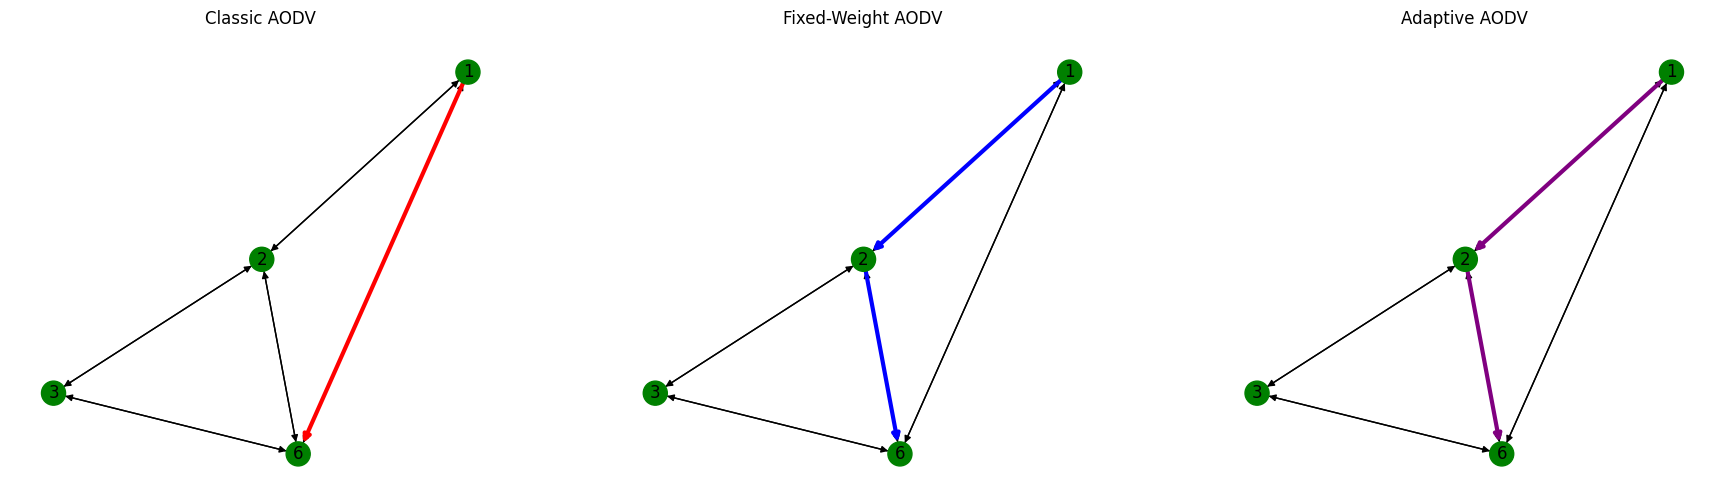

In [41]:
print("\nCOMPARING CLASSIC AODV WITH IMPROVED (FIXED & ADAPTIVE WEIGHTS)")

test_case_1_three()
test_case_2_three()
test_case_3_three()
